In [1]:
import pickle
import radvel
import rebound as rb
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from scipy import optimize, stats
import corner
from radvel.plot import mcmc_plots
import reboundx
import emcee
from multiprocessing import Pool
import h5py
import time
from celmech.nbody_simulation_utilities import align_simulation
from tqdm import tqdm
from emcee.interruptible_pool import InterruptiblePool
import os
from getdist import plots, MCSamples
%matplotlib inline

/home/ichow9/.conda/envs/wmpl/lib/python3.10/site-packages/radvel/gp.py:32: ImportWarning: celerite not installed. GP kernals using celerite will not work. Try installing celerite using 'pip install celerite'
  warnings.warn("celerite not installed. GP kernals using celerite will not work. \


In [2]:
pl.rc('font', size=18)

In [3]:
MAY_1_2015 = 57143.5  # barycentric julian date for May 1, 2015 (the date of the HARPS instrument upgrade as per trifonov et al 2020)
# 57143.5 is BJD for May 1, 2015
# 57173.5 is BJD for May 31, 2015

# exostriker
exostriker_hd_data = pd.read_csv('./exostriker_hd45364_rv_data.csv', sep=',')

In [4]:
def target_func(row):
    if row.target == 1.0:
        return 'HARPS1'
    if row.target == 2.0:
        return 'HARPS2'
    if row.target == 3.0:
        return 'HIRES'

hd_data_mod = exostriker_hd_data.copy()
hd_data_mod.columns = ['BJD', 'RV_mlc_nzp', 'e_RV_mlc_nzp', 'target', 'oc', 'model', 'model1', 'model2', 'test']
hd_data = hd_data_mod.copy()
hd_data['target'] = hd_data_mod.apply(target_func, axis=1)
hd_data.BJD -= 2.4e6

# fit params
fit_params = ([ 2.25638612e+02,  7.29205979e+00,  5.28083116e+04,  7.39686309e-03,
       -2.80725470e-01,  3.45356466e+02,  1.81870570e+01,  5.29845857e+04,
        1.74856643e-02,  1.25751168e-02,  1.28654922e-01,  1.35079661e-03,
        5.96071487e-01,  1.00000000e+00,  1.42296165e+00,  8.48880201e-01,
        4.32096766e+00])


obs_time_base = 52984.709
# obs_time_base = np.median(hd_data.BJD)

In [5]:
## CONSTANTS:

# STAR_MASS = 920  # 920 jupiter masses
STAR_MASS = 859
G = 2.825e-7  # converting G to jupiter masses, au, and days
AUDAY_MS = 1.731e6  # conversion factor for au/day to m/s

# obs_time_base = np.median(hd_data_harps.BJD)
# obs_time_base = np.min(hd_data_harps.BJD)

# print(f'nbody_params:{nbody_params}\n fit_params:{fit_params}')

def mass_to_semiamp(planet_mass, star_mass, period, eccentricity, inclination):
    """
    planet mass (jupiter masses) to semi amplitude (in au/day)
    """
    return ((2 * np.pi * G/period) ** (1/3) * (planet_mass * np.sin(inclination) / star_mass ** (2/3)) * (1/np.sqrt(1 - eccentricity ** 2)))


def semiamp_to_mass(semiamp, star_mass, period, eccentricity, inclination):
    """
    semi amplitude (in au/day) to planet mass (jupiter masses)
    """
    return (((2 * np.pi * G/period) ** (-1/3)) * (semiamp / np.sin(inclination)) * np.sqrt(1 - eccentricity ** 2) * (star_mass ** (2/3)))


def get_sim_from_params(params, integrator, time_base, star_mass = STAR_MASS, auday_ms = AUDAY_MS):
    """
    takes in params array, returns a rebound Simulation object with those parameters
    
    param params: numpy array of params:
    
    for i in range(0, num_planets):
    
    params[i + 0] is period
    params[i + 1] is semiamp
    params[i + 2] is tc (time of conjunction)
    params[i + 3] is sqrt(e) * cos(omega)
    params[i + 4] is sqrt(e) * sin(omega)
    
    params[5 * num_planets] is rv offset for HARPS1
    params[5 * num_planets + 1] is rv offset for HARPS2
    params[5 * num_planets + 2] is rv offset for HIRES
    params[5 * num_planets + 3] is sin(i)
    params[5 * num_planets + 4] is jitter for HARPS1
    params[5 * num_planets + 5] is jitter for HARPS2
    params[5 * num_planets + 6] is jitter for HIRES
    
    param integrator: integrator to use, one of 'whfast' or 'ias15'
    param time_base: base time (to begin integration from) in the simulation
    """
    
    num_planets = 2 # 2 planets
    
    sim = rb.Simulation()
    sim.integrator = integrator
    sim.t = time_base  # keplerian and n-body models initialized at the same time offset
    # print(sim.t)
    if integrator == 'whfast':  # if using whfast integrator, set timestep
        sim.dt = 1/50 * np.min([params[0], params[5]])  # timestep is 1/20th of the shortest orbital period of any planet
        # print(sim.dt)
    sim.units = ('AU', 'Mjupiter', 'day')
    sim.add(m = star_mass)  # star mass as a constant
    
    inclination = np.arcsin(params[-4])  # sin(i) is fourth from the back of the array
        
    for i in range (0, num_planets):
        # print(i)
        # planet parameters
        period = params[5*i]  # in days
        semiamp = params[5*i + 1] / auday_ms # divide by auday_ms because semiamp given in m/s
        eccentricity = params[5*i + 3] ** 2 + params[5*i + 4] ** 2  # eccentricity from secos, sesin
        omega = np.arctan2(params[5*i + 4], params[5*i + 3])  # omega from arctan of sesin, secos  (in that order!)
        # get tp by converting from tc
        tp = radvel.orbit.timetrans_to_timeperi(tc = params[5*i + 2], per = period, ecc = eccentricity, omega = omega)
        
        # mass
        mass = semiamp_to_mass(semiamp = semiamp, star_mass = star_mass, period = period, eccentricity = eccentricity, inclination = inclination)
        
        # adding to simulation
        sim.add(m = mass, P = period, e = eccentricity, T = tp, omega = omega, inc = inclination)
        
    sim.move_to_com()  # move to center of mass
    
    return sim

def get_simple_sim(masses, integrator = 'ias15', period_ratio = 3/2, epsilon=0.01):
    """
    gets simple sim (for eccentricity track stuff)
    param masses: array of planet masses
    param integrator: integrator
    param epsilon: amount by which the resonant period ratio should be offset from the equilibrium in the simulation
    """
    sim = rb.Simulation()
    sim.integrator = integrator
    # central star
    sim.add(m = 1)
    
    sim.add(m = masses[0], P = 1)
    sim.add(m = masses[1], P = period_ratio * (1 + epsilon))

    sim.move_to_com()
    if integrator == 'whfast':
        sim.dt = 1/50 * 1  # dy default use 1/50th of the inner planet's orbital period for the timestep if using whfast
    return sim


def get_rvs(params, instrument, times, integrator, time_base, auday_ms = AUDAY_MS):
    
    """
    Gets RVs from a Numpy array of planet params
    
    param params:     for i in range(0, num_planets):
    
    params[i + 0] is period
    params[i + 1] is semiamp
    params[i + 2] is tc (time of conjunction)
    params[i + 3] is sqrt(e) * cos(omega)
    params[i + 4] is sqrt(e) * sin(omega)
    
    params[5 * num_planets] is rv offset for HARPS1
    params[5 * num_planets + 1] is rv offset for HARPS2
    params[5 * num_planets + 2] is rv offset for HIRES
    params[5 * num_planets + 3] is sin(i) (also params[-4])
    params[5 * num_planets + 4] is jitter for HARPS1 (also params[-3])
    params[5 * num_planets + 5] is jitter for HARPS2 (also params[-2])
    params[5 * num_planets + 6] is jitter for HIRES (also params[-1])

    param instrument: instrument (HARPS1, HARPS2, or HIRES)
    param times: array of times to integrate over
    param integrator: integrator to use, one of 'whfast' or 'ias15'
    
    """
    
    sim = get_sim_from_params(params, integrator, time_base = time_base)
    
    sim_backwards = sim.copy()
    sim_backwards.dt *= -1  # set timestep to be negative if integrating backwards

    times = pd.Series(times)  # convert to series if not already
    
    forward_times = times[times - time_base >= 0]
    backward_times = times[times - time_base < 0]
    forward_indices = forward_times.index
    backward_indices = backward_times.index
    
    # initialize rvs
    rv_forward = np.zeros(len(forward_times))
    rv_backward = np.zeros(len(backward_times))
    
    num_planets = 2  # find number of planets in params passed
    
    # get the rvs (z velocity, assuming 90 deg inclination) from the rebound simulation to compare with the actual simulation
    for j, it in enumerate(zip(forward_indices, forward_times)):
        i, t = it  # forward index, forward time
        sim.integrate(t, exact_finish_time = 1)
        # integrate to the specified time, exact_finish_time = 1 for ias15, 
        # sim.status()
        star = sim.particles[0]
        # print(instrument[i])
        # use one of 3 different radial velocity offsets depending on whether the data is from HARPS1, HARPS2 or HIRES
        if instrument[i] == 'HARPS1':
            rv_offset = params[5 * num_planets]
        elif instrument[i] == 'HARPS2':
            rv_offset = params[5 * num_planets + 1]
        elif instrument[i] == 'HIRES':
            rv_offset = params[5 * num_planets + 2]
        else:
            rv_offset = 0.
        rv_forward[j] = (-star.vz * auday_ms) + rv_offset  # use x-velocity of the star as the radial velocity, convert to m/s
    
    for j, it in enumerate(zip(backward_indices, backward_times)):
        i, t = it  # backward index, backward time
        sim_backwards.integrate(t, exact_finish_time = 1)
        star = sim_backwards.particles[0]
        # use one of 3 different radial velocity offsets depending on whether the data is from HARPS1, HARPS2 or HIRES
        # print(instrument[i])
        if instrument[i] == 'HARPS1':
            rv_offset = params[5 * num_planets]
        elif instrument[i] == 'HARPS2':
            rv_offset = params[5 * num_planets + 1]
        elif instrument[i] == 'HIRES':
            rv_offset = params[5 * num_planets + 2]
        else:
            rv_offset = 0.
        rv_backward[j] = (-star.vz * auday_ms) + rv_offset
    
    return np.concatenate((rv_backward, rv_forward))

In [6]:
def get_nbody_resids(params, integrator, data = hd_data):
    """
    Gets the normalized residuals for the n-body fit with REBOUND
    """
    obs_y = data.RV_mlc_nzp  # observed RVs
    synth_y = get_rvs(params, data.target, data.BJD, integrator, time_base=obs_time_base)  # RVs from the rebound simulation
    obs_yerr = data.e_RV_mlc_nzp  # y errors
    return (obs_y - synth_y) / obs_yerr  # return normalized residuals


def neg_log_likelihood(params, time_base = obs_time_base, data = hd_data, num_planets = 2):
    """
    Gets the negative log-likelihood (including a jitter term!) for use with scipy.optimize.minimze
    
    Iplements the log likelihood using the same method above
    
    """
    obs_y = data.RV_mlc_nzp  # observed RVs
    
    # inclination not handled sparately
    # inclination = np.arcsin(params[-4])  # inclination is np.arcsin of the second to last parameter
    
    synth_y = get_rvs(params, data.target, data.BJD, 'ias15', time_base = time_base)  # RVs from the rebound simulation
    obs_yerr = data.e_RV_mlc_nzp  # y errors

    conditions = [data.target == 'HARPS1', data.target == 'HARPS2', data.target == 'HIRES']  # conditions are harps1, harps2 or hires

    rv_offsets = params[5 * num_planets:5 * num_planets + 3]  # rv_offsets for HARPS1, HARPS2 and HIRES, in that order
    jitters = params[-3:]  # jitters for HARPS1, HARPS2 and HIRES, in that order
    
    # get the jitter and rv values for the corresponding data points
    rv_offset = np.select(conditions, rv_offsets, default=np.nan)
    jitter = np.select(conditions, jitters, default=np.nan)
    # print(rv_offset, jitter)

    # compute the log-likelihood
    #### OLD
    # log_likelihood = -1/2 * np.sum(((obs_y - synth_y) ** 2)/(obs_yerr ** 2 + jitter ** 2) 
    #                                + np.log(np.sqrt(2 * np.pi * (obs_yerr ** 2 + jitter ** 2))))

    #### LI ET AL. 2022 VERSION (NEW)
    # sigma_z2 = 1/(np.sum(1/(obs_yerr ** 2 + jitter ** 2)))
    log_likelihood = -1/2 * np.sum(((obs_y - synth_y) ** 2)/((obs_yerr ** 2 + jitter ** 2))) - np.sum(np.log(np.sqrt(2 * np.pi * (obs_yerr ** 2 + jitter ** 2)))) # + np.log(np.sqrt(2 * np.pi * sigma_z2))
    # log_likelihood = -1/2 * np.sum(np.log(variance) + ((obs_y - synth_y) ** 2/variance))    
    # print(-1/2 * np.sum(((obs_y - rv_offset - synth_y) ** 2)/((obs_yerr ** 2 + jitter ** 2))))
    # print(-log_likelihood)
    return -log_likelihood  # negative since we are trying to minimize the negative log likelihood

Exostriker comparison:

<ErrorbarContainer object of 3 artists>

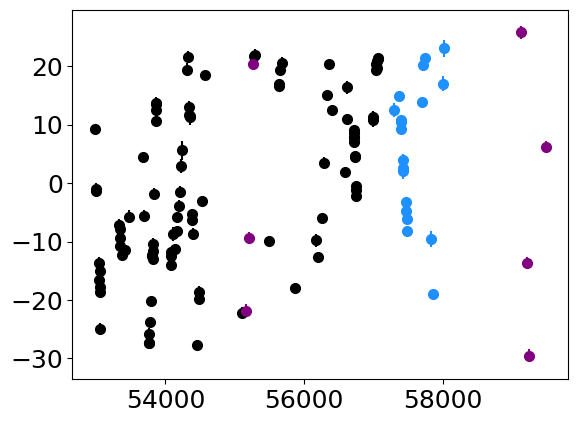

In [7]:
pl.errorbar(hd_data[hd_data.target == 'HARPS1'].BJD, hd_data[hd_data.target == 'HARPS1'].RV_mlc_nzp, 
            yerr = hd_data[hd_data.target == 'HARPS1'].e_RV_mlc_nzp, fmt = 'o', markersize=7, label = 'HARPS1', color='black', alpha=1.)
pl.errorbar(hd_data[hd_data.target == 'HARPS2'].BJD, hd_data[hd_data.target == 'HARPS2'].RV_mlc_nzp, 
            yerr = hd_data[hd_data.target == 'HARPS2'].e_RV_mlc_nzp, fmt = 'o', markersize=7, label = 'HARPS2', color='dodgerblue', alpha=1.)
pl.errorbar(hd_data[hd_data.target == 'HIRES'].BJD, hd_data[hd_data.target == 'HIRES'].RV_mlc_nzp, 
            yerr = hd_data[hd_data.target == 'HIRES'].e_RV_mlc_nzp, fmt = 'o', markersize=7, label = 'HIRES', color='purple', alpha=1.)

In [8]:
neg_log_likelihood(fit_params)# , neg_log_likelihood(trifonov_params)

233.49051744317225

logL maximization:

In [9]:
# bounds = ([-np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, 0], 
#           [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, 1])

# fit_params = optimize.least_squares(lambda params: get_nbody_resids(params, integrator = 'ias15'), nbody_params, bounds=bounds)

def ecc_con1(params):
    return 1 - (params[3] ** 2 + params[4] ** 2)

def ecc_con2(params):
    return 1 - (params[8] ** 2 + params[9] ** 2)

cons = ({'type': 'ineq', 'fun': ecc_con1}, 
        {'type': 'ineq', 'fun': ecc_con2})

# bounds of (0, 1) for sin(i), everything else can vary however
bounds = ((None, None), (None, None), (None, None), (None, None), (None, None), 
          (None, None), (None, None), (None, None), (None, None), (None, None), 
          (None, None), (None, None), (None, None),
          (0, 1), 
          (None, None), (None, None), (None, None))
#### BFGS and L-BFGS do not work without hacky fixes (returns RV array full of nans (ecc greater than 1))
#### Nelder-Mead seems to work...
best_fit_jitter = optimize.minimize(neg_log_likelihood, x0=np.array(fit_params), method='Nelder-Mead', 
                                    bounds=bounds, constraints=cons, options={'maxiter': 1000000000000, 
                                                                              'maxfev': 1000000000000, 
                                                                              # 'ftol': 1.e-7
                                                                             }
                                   )  # optimization

In [10]:
best_fit_jitter.x

array([ 2.25426732e+02,  7.30394654e+00,  5.28093363e+04,  1.54189571e-02,
       -2.64986489e-01,  3.45487052e+02,  1.81882134e+01,  5.29848836e+04,
       -5.11213849e-02,  8.01593684e-02, -7.56025400e-03,  4.82848910e-03,
       -8.95688663e-01,  1.00000000e+00,  1.42343480e+00,  6.71351801e-01,
        2.99513165e+00])

In [11]:
neg_log_likelihood(best_fit_jitter.x), neg_log_likelihood(fit_params)

(231.75963409140115, 233.49051744317225)